# Lab 07 : Problem Solving (part 2)

## Objectives

This is the second part of a two part lab.  **The solutions to this and the previous lab will be posted at the same time**.

Ideally, the main lesson from this lab will be that despite all the care and testing we put into the previous lab, there will still be a subtle error in that work!

We will put together things from our prevous lab and prelab.  We will create a generic implementation of the Newton-Raphson method, use it to solve our system of equations, discover there is a problem, and fix it!

## Initialization

As always, initialize your environment now by loading all modules required and setting up the plotting environment.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la
%matplotlib inline
import scipy.interpolate as interp
import scipy.special as sf
import scipy.integrate as integ
import scipy.optimize as opt
import matplotlib as mpl
mpl.rc('xtick', direction='in', top=True)
mpl.rc('ytick', direction='in', right=True)
mpl.rc('xtick.minor', visible=True)
mpl.rc('ytick.minor', visible=True)

## Static Mass-Spring Configuration

In the previous lab we began studying the mass-spring system shown below.

![Static mass-spring system.](https://github.com/cwru-phys-250/p250-spring-2021/raw/main/figures/static_springs.png)

We wish to find the static configuration for this system.  As stated in the previous lab, we are going to do this by finding the lengths, $\ell_i$, and angles, $\theta_i$, for the springs given the normalized spring constants, $\kappa_i$ and the normalized masses $\mu_j$.

In the previous lab you wrote a function that implemented the static conditions which much be satisfied as a system of non-linear equations of the form $\vec f(\vec y) = 0$.

Copy your function from the previous lab but now call it `static_conditions_lab6`.  This may not be the final form ....

In [112]:
def static_conditions_lab6 (y, l0, kappa, mu) :
    """Returns a system of equations corresponding to the passed parameters (final conditions, normalized
    natural lengths, normalized spring constants, and normalized masses).
    Parameters
    ----------
    y       Array of final lengths and angles of system
            y[0] = Final length of spring 1
            y[1] = Final length of spring 2
            y[2] = Final length of spring 3
            y[3] = Final angle of spring 1 (in radians)
            y[4] = Final angle of spring 2 (in radians)
            y[5] = Final angle of spring 3 (in radians)
    l0      Array of three natural lengths
            l0[0] = Natural length of spring 1
            l0[1] = Natural length of spring 2
            l0[2] = Natural length of spring 3
    kappa   Array of three normalized spring constants
            kappa[0] = Normalized constant for spring 1
            kappa[1] = Normalized constant for spring 2
            kappa[2] = Normalized constant for spring 3
    mu      Array of normalized masses
            mu[0] = Normalized mass 1
            mu[0] = Normalized mass 2
    """
    sol = np.zeros_like(y)
    sol[0] = kappa[0]*(y[0]-l0[0])*np.cos(y[3]) - kappa[2]*(y[2]-l0[2])*np.cos(y[5])
    sol[1] = - mu[0] + kappa[0]*(y[0]-l0[0])*np.sin(y[3]) + kappa[2]*(y[2]-l0[2])*np.sin(y[5])
    sol[2] = - kappa[2]*(y[2]-l0[2])*np.cos(y[5]) + kappa[1]*(y[1]-l0[1])*np.cos(y[4])
    sol[3] = - mu[1] - kappa[2]*(y[2]-l0[2])*np.sin(y[5]) + kappa[1]*(y[1]-l0[1])*np.sin(y[4])
    sol[4] = y[0]*np.cos(y[3]) + y[1]*np.cos(y[4]) + y[2]*np.cos(y[5]) - 1
    sol[5] = - y[0]*np.sin(y[3]) + y[1]*np.sin(y[4]) + y[2]*np.sin(y[5])
    return sol

## Newton-Raphson Method

As discussed in class and shown in the example this week, we can use the Newton-Raphson method to solve a system of non-linear equations.  We saw that the Newton-Raphson method is an iterative algorithm.  Let $\vec y_n$ be a guess for the desired solution.  An improved guess is given by
$$ \vec y_{n+1} = \vec y_n + \Delta\vec y = \vec y_n - \mathsf{J}_{\vec f}^{-1}(\vec y) \vec f(\vec y), $$
where $\mathsf{J}_{\vec f}(\vec y)$ is the Jacobian matrix. From an initial guess, $\vec y_0$, we iteratively improve our estimate and stop when convergence has been obtained, that is, when the correction becomes sufficiently small.

### Jacobian Matrix

As we have seen, the Jacobian matrix is the matrix of first derivatives of the function.  Written more explicitly
$$
\mathsf{J}_{\vec f} (\vec y) = \begin{pmatrix}
\frac{\partial f_1}{\partial y_1} & \frac{\partial f_1}{\partial y_2} & \cdots \\
\frac{\partial f_2}{\partial y_1} & \frac{\partial f_2}{\partial y_2} & \cdots \\
\vdots & \vdots & \ddots
\end{pmatrix}
$$

This matrix can be calculated analytically or numerically.  Just as in the prelab, we will do so numerically using center differencing.  Thus, just knowing $\vec f(\vec y)$ and step sizes $\vec h$ (potentially different step sizes for each coordinate) we can construct the Jacobian matrix.  Here you can use your work from the prelab with a small generalization.

Write a function for calculating the Jacobian matrix at a point $\vec y$ using center differencing with step sizes $\vec h$ for a system of equations described by a function $\vec f(\vec y)$.  The idea is the same as in the prelab, but here we now allow for this function to take extra arguments.  Though we could require the use of `lambda` function, we will not, we will instead use `args`.  As always, document your function!

*Note:* Unlike the prelab, we will not do the manipulations of the stepsize, `h`, in this function.  The user is expected to provide the correct step sizes.  This is a better design.  You should not punish users who are careful by slowing down your functions to accomodate those who are not careful.

In [113]:
def Jacobian(f, y, h, args=()) :
    """Uses center differencing to numerically calculate the Jacobian of a system.
    Parameters
    ----------
    f : function
        The eqaution or system of equations that model the system used to evaluate the Jacobian.
    x : array
        Points at which the function is evaluated.
    h : array (like size of x)
        Step size(s) used during center differencing; they are not modified in the function.
    args
        Additional parameters.
    Returns
    -------
    sol : array (2 dimentional square array with row and column sizes like x)
        The numerically calculated Jacobian of the function at the given points.
    """
    h = np.diag(h)
    y_add = (y + h).T
    y_sub = (y - h).T
    sol = np.dot((f(y_add, *args)-f(y_sub, *args)),la.inv(2.*h))
    return sol

### Newton-Raphson Implementation

We can now finally implement the Newton-Raphson method where we will calculate the Jacobian numerically.  As we have done for the Jacobian itself, this can be written in a generic way. Since the Newton-Raphson method works for any set of functions and associated Jacobian matrix, we can write an implementation that is independent of the particular problem we are solving.  Here we can pass in all the relevant functions.  In writing such a generic implementation, we allow for the specification of the desired convergence tolerances (absolute in `atol` and relative in `rtol`).  Finally, as noted in the example from this week, whenever we have an algorithm that depends on a convergence criterion to end we must specify a maximum number of iterations to allow.  Without this it is possible (and even likely) that we will encounter a case that never converges and thus the algorithm will never complete!

Implement the Newton-Raphson iteration scheme in a function of the form given below.

Here `f` is Python function that evaluates the set of functions for which we are finding roots and will be called as `f(y, *args)`, `Jacobian` computes the Jacobian matrix for the set of functions using center differencing with steps sizes given in `h` and will be called as defined above, `y0` is our initial guess at the roots, `itermax` is the maximum number of iterations allowed, and `atol` and `rtol` are the desired absolute and relative tolerances.

Your function should return the best estimate of the roots (in a NumPy array) and the number of iterations required, as a tuple.

In [105]:
def newton_raphson_iterate(f, Jacobian, y0, h, itermax, args=(), atol=1e-10, rtol=1e-10) :
    y = y0.copy()
    niter = 1
    while niter <= itermax :
        J = Jacobian(f, y, h, args)
        dy = np.dot(la.inv(J), f(y, *args))
        y -= dy
        if np.allclose(np.zeros_like(dy), dy, atol, rtol) :
            break
        niter += 1
    return (y, niter)

### Visualization

One test we will do to verify if our results make sense is to visualize the system.  You worked on this in the previous lab, we will now actually use it.

Copy your visualization code from the previous lab.

In [106]:
def visualize_system (lengths, angles) :
    """Returns a plot depicting the final normalized positions of both the masses and the endpoints (as well as the path of the spring) of the static mass system.
    
    Parameters
    ----------
    lengths[0] = Final length of spring 1
    lengths[1] = Final length of spring 2
    lengths[2] = Final length of spring 3
    angles[0] = Final angle of spring 1 (in radians)
    angles[1] = Final angle of spring 2 (in radians)
    angles[2] = Final angle of spring 3 (in radians)
    """
    # Calculating Positions
        # Note: Remember Spring 3 (so the last angle and the last length) is technically the middle spring based on our system setup
    x_points = np.zeros(4)
    y_points = np.zeros(4)
    x_points[1] = x_points[0] + lengths[0]*np.cos(angles[0])
    y_points[1] = y_points[0] - lengths[0]*np.sin(angles[0])
    x_points[2] = x_points[1] + lengths[2]*np.cos(angles[2])
    y_points[2] = y_points[1] + lengths[2]*np.sin(angles[2])
    x_points[3] = x_points[2] + lengths[1]*np.cos(angles[1])
    y_points[3] = y_points[2] + lengths[1]*np.sin(angles[1])
    
    # Plotting the System
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(x_points[0::3],y_points[0::3], color ='k',label = "Location of Endpoints")
    ax.scatter(x_points[1:3:1],y_points[1:3:1], color ='b',label = "Location of Masses")
    ax.plot(x_points,y_points,'k:', label = "Path of Spring")
    ax.set_title("Visualization of 2-Mass Spring System")
    ax.annotate(f"({np.around(x_points[1],2)},{np.around(y_points[1],2)})",(x_points[1],y_points[1]))
    ax.annotate(f"({np.around(x_points[2],2)},{np.around(y_points[2],2)})",(x_points[2],y_points[2]))
    ax.set_xlabel("Normalized x-displacement (units of d)")
    ax.set_ylabel("Normalized y-displacement (units of d)")
    ax.set_xlim([-0.05,1.05])
    ax.legend()
    return ax

### Example System

There are many things we can do to test our code.  A reasonable approach would be to take the tests you defined in the previous lab, start from initial guesses **not exactly** correct, and see that the correct solutions are recovered.  I will leave it to you to do any such tests.

The example system we will consider is the following mostly arbitrary one.

For the springs let the natural lengths in units of $d$ be given by $\ell_{0,1}=0.7$, $\ell_{0,2}=0.45$, and $\ell_{0,3}=0.2$, and the normalized spring constants be $\kappa_1=1.1$, $\kappa_2=2$, and $\kappa_3=0.6$.  Let the normalized masses be $\mu_1=3$ and $\mu_2=1.4$.  Choose as initial guesses $\ell_1=0.9$, $\ell_2=0.55$, $\ell_3=0.4$, $\theta_1=\pi/4$, $\theta_2=\pi/5$, and $\theta_3=\pi/8$.  Finally, use step sizes of $1\times10^{-5}$ for all the lengths and $2\times10^{-5}$ for all the angles when calculating the Jacobian matrix.
(*Note:* The signs for all of these angle are positive and positive means the directions shown in the figure at the top of the lab.)

Implement the above choices and use your code to solve for the static configuration.  Print the final results for the length and the angles (clearly organized) along with the number of iterations required to converge to a solution. Also produce a visualization of the static configuration.

We find the final results to be the following:
l1= -1.8169138575256996 
l2= 1.283964194515476 
l3= 0.8140198742985666 
theta1= 4.61287566151783 
theta2= 1.4051292487766283 
theta3= 0.7278505180348336 
It will take us 12 iterations to find these values.


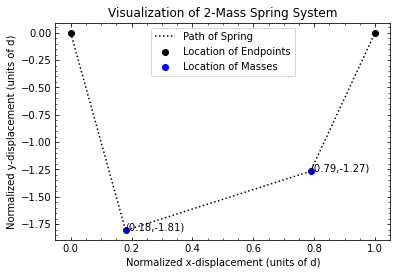

In [114]:
y0 = np.array([0.9, 0.55, 0.4, np.pi/4, np.pi/5, np.pi/8])
l0 = np.array([0.7, 0.45, 0.2])
kappa = np.array([1.1, 2, 0.6])
mu = np.array([3, 1.4])

z = 1e-5
h1_i = 1e-5
h2_i = 2e-5
h1_i = h1_i + z
h2_i = h2_i + z
h1 = h1_i - z
h2 = h2_i - z
h = np.array([h1, h1, h1, h2, h2, h2])
sol = newton_raphson_iterate(static_conditions_lab6, Jacobian, y0, h, 50, args=(l0, kappa, mu))
print("We find the final results to be the following:\nl1=", sol[0][0], "\nl2=", sol[0][1], "\nl3=", sol[0][2], "\ntheta1=", sol[0][3], "\ntheta2=", sol[0][4], "\ntheta3=", sol[0][5], "\nIt will take us", sol[1], "iterations to find these values.")
visualize_system(sol[0][0:3], sol[0][3:6]);

Comment on your results.  Do they seem reasonable?  Does anything seem strange or worrisome?

In a physical sense, these answers are non-sensical. First, we have a length ($l_1$) that is negative, which just doesn't make sense from a physical standpoint. Also, $\theta_1$ is well outside the expected range (from 0 to pi). These combined factors end up cancelling each other out numerically, meaning that we still have a physical equilibrium. We could set up the same system by taking the negative of $l_1$ and subtracting pi from $\theta_1$, which would give us a system still in equilibrium that would make sense from a physical perspective.

### Further Tests

At this point we should have a code that runs and produces reasonable looking results.  But are they *correct*?  This is always difficult to know.  The best we can do is test our results in every way we can think of.  We would not want to publish results only to later discover they are "obviously" wrong!

Another way to test our results is to use a different method to calculate them.  In our case there are many algorithms implemented in `scipy.optimize` that will also solve a system of equations.  In particular, we can use `scipy.optimize.root`.  This is a generic function that implements a number of different algorithms.  It is called similar to how we have written `newton_raphson_iterate` so we should be able to just use the function we have written for evaluating our system of equations, along with the initial guess, and see what solution it finds.  We should try multiple methods and see if we get consistent results.

Use `scipy.optimize.root` with your function `static_conditions_lab6` and the system defined above to solve for the static system.  (You should not use your Jacobian function, these methods will calculate the Jacobian themselves using their own algorithms.)  You will need to look at the documentation for this function and play around a bit to determine how to use it and how to extract the results.  Check at least two different methods.  The expectation is that you will at least find **a different result** from yours and you may even find different results for different methods.  By different results we mean that the systems are physically different as seen in your visualizations. Print the different result (or results if you prefer) and visualize it along with your solution.  Since this is a "quick test" you do not need to print them in elegant form if you do not want to.  (*Note:* For my implementation using at least the `hybr` and `broyden1` methods I get different results.  What results you get will depend on your implementation.)

[2.82275513 1.49768823 1.41156123 1.45977596 1.44701639 1.20693856]
[2.82275513 1.49768823 1.41156123 1.45977596 1.44701639 1.20693856]
[ -1.48852142  -0.58883114  -1.07714664  92.49597077 136.4491428
  60.65993337]


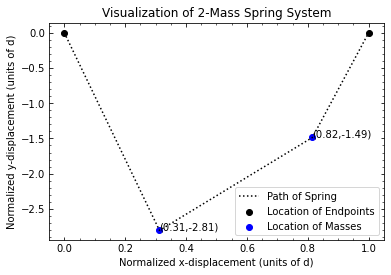

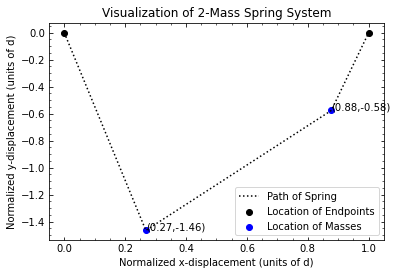

In [115]:
y0 = np.array([0.9, 0.55, 0.4, np.pi/4, np.pi/5, np.pi/8])
sol_1 = opt.root(static_conditions_lab6, y0, args=(l0, kappa, mu), method='hybr')
sol_2 = opt.root(static_conditions_lab6, y0, args=(l0, kappa, mu), method='lm')
sol_3 = opt.root(static_conditions_lab6, y0, args=(l0, kappa, mu), method='broyden1',tol=1e-12)
print(sol_1.x)
print(sol_2.x)
print(sol_3.x)

visualize_system(sol_1.x[0:3],sol_1.x[3:6])
visualize_system(sol_3.x[0:3],sol_3.x[3:6]);

Assuming that we have (at least) two different solutions we have to ask the question, does that make sense?  Here is the most difficult thing when solving numerical problems (or more generally when moving from solving homework problems to solving research problems).  We can easily verify that these are solutions to our equations (plug them back in and see that they do give $\vec f(\vec y)=0$).  But, physically, can there be more than one solution?  Remember, we are not solving a mathematics problem here, we are trying to model nature.  If we set up a real mass-spring system could we put it in more than one static configuration?

Our thought process might be something like:
- No!  There must only be one static configuration.
- Well, if the system were symmetric then maybe, ..., but our system is not symmetric so that does not matter.
- Hmm, I could imagine that if I moved mass 2 to the left of mass 1 then I could find a static configuration.  Of course it might not be stable to small perturbations, but that is ok.  But we see that our two solutions above do not follow this pattern. (Plus we would not find such a solution numerically using an iterative algorithm.)
- Maybe there could be two configurations, one where some of the springs are compressed and other are stretched, and which ones are stretched and compressed can be changed around to balance the forces in different ways ... but again, that is not what these solutions do.
- Of course this is a non-linear problem and non-linear problems are notorious for having multiple solutions (local extrema).  However, this is also a physical problem and the question ultimately reduces to whether or not a physical system can have multiple stable configurations of the type we have found.

After going over this again and again we ultimately need to decide if we believe both of these solutions.  It is good to do this yourself.  When developing the lab we needed to do precisely this!

In the end, both of these solutions cannot be correct, there must be something wrong.  Since these are valid solutions to our equations we must have implemented the Newton-Raphson method correctly.  This must mean there is something wrong with the equations we derived.

### Choice of Variables

When we started this problem last lab, it probably seemed reasonable to use lengths and angles as variables.  This choice does impose some implicit assumptions.  If we were solving the problem analytically, we would implicitly always choose lengths to be positive and angles to be between $0$ and $2\pi$.  Numerically, no such restrictions are imposed.  In fact, it is quite likely that our solutions do not satisfy these constraints.  Of course there is nothing special about these constraints.  It is perfectly valid to have a negative "length" as long as the angle compensates for this.

To make it easier to understand our results it makes sense to convert them to a "standard form".  Here standard form means that all angles are between $0$ and $2\pi$ (actually for $\theta_3$ it would make sense to allow it to be between $-\pi$ and $\pi$, we will not treat it as a special case in what we do here), and all lengths are positive.  To achieve this we can use the modulo operator, `%`, which works for floating point numbers as well as integers.  Further, using array slicing (with boolean arrays or the `where` function), we can map any negative length to a positive length if we also change the angle by $\pi$.  In other words, for any negative $\ell_i$ we can map it as $\ell_i \rightarrow -\ell_i$ if we also map the angle $\theta_i \rightarrow \theta_i-\pi$.

Write a function with the form given below that returns the remapped lengths and angles as described above.  **Do not change the input arrays.**  Make sure you always make a copy of the array in your function before making any changes.

In [65]:
def to_standard_form (lengths, angles) :
    l_new = lengths.copy()
    a_new = angles.copy()
    a_new = np.where(l_new>0, a_new, a_new-np.pi)
    a_new = (a_new)%(2.*np.pi)
    l_new = np.abs(l_new)
    sol = np.append(l_new,a_new)
    return sol

# Test Case
l = np.array([-17,-5,-4.])
a = np.array([np.radians(270),np.radians(0),np.radians(45)])
print(to_standard_form(l,a))
print("We see that our test case worked successfully!")

[17.          5.          4.          1.57079633  3.14159265  3.92699082]
We see that our test case worked successfully!


Convert your solution to standard form.  Again print the results and visualize the system.  **The visualization cannot have changed.**  If it did then your conversion is incorrect.  Finally, evaluate your function containing the system of equations and see if the standard form is a solution.  If things have gone as intended it will *not be a solution*!

[2.82275513 1.49768823 1.41156123 1.45977596 1.44701639 1.20693856]
We see that our new system is identical to our old system in a physical sense, though we have correctly changed it into standard form!


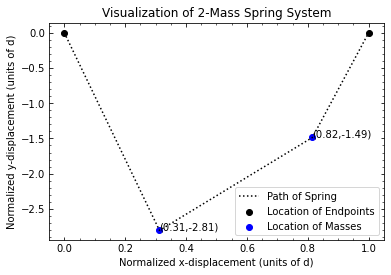

In [117]:
sol_new_1 = to_standard_form(sol_1.x[0:3],sol_1.x[3:6])
print(sol_new_1)
visualize_system(sol_new_1[0:3],sol_new_1[3:6])

Under the assumption that you found multiple solutions using `scipy.optimize.root`, repeat the previous part for another solution you found.  Is this a valid solution?

[1.48852142 0.58883114 1.07714664 1.38978382 1.36065869 0.96967295]
We see that our new system is identical to our old system in a physical sense, though we have correctly changed it into standard form!
This is still an invalid solution. All we've done is convert it into standard form.


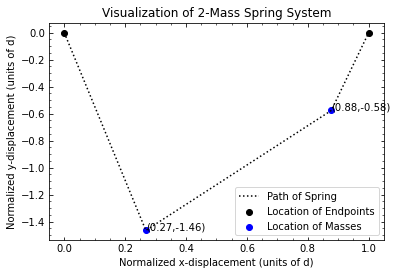

In [121]:
sol_new_3 = to_standard_form(sol_3.x[0:3],sol_3.x[3:6])
print(sol_new_3)
visualize_system(sol_new_3[0:3],sol_new_3[3:6])
print("We see that our new system is identical to our old system in a physical sense, though we have correctly changed it into standard form!\nThis is still an invalid solution. All we've done is convert it into standard form.")

### Fixing the Problem

At this point we should see that there is a problem.  We have two "solutions" but only one of them actually is a solution.  How did this happen?  There must be something wrong with how we wrote down our system of equations!

Describe the error made in deriving the equations and how to correct it.  As some guidance, you should find that the problems occur when the length is negative.  Where does this affect our derivation?  Why does a negative length cause a problem?  You should think about this and discuss it as a group.  If you are stuck after struggling together you should then discuss your ideas with one of the instructors.  It is good to struggle for some time with this (this is how we learn) but ultimately we do want to resolve the issue and be able to correct it.

The error made in deriving the equaiton was that we assumed that the lengths would always be positive. Physically, this is a correct assumption. But, in order to ensure that these lengths remain positive numerically (during our application of the Newton-Raphson method), we need to 'fix' the set of values at each iteration. We must fix this problem because, otherwise, we might converge to some physically nonsensical solution (i.e. involving negative lengths). We can correct this issue by using the `to_standard_form` function we defined above. Moreover, we can ensure that the solution we get from `opt.root` is physically meaningful by converting it with `to_standard_form(lengths, angles)`.

Implement your fix in a new function, now again called `static_conditions`.

In [101]:
def static_conditions (y, l0, kappa, mu) :
    """Returns a system of equations corresponding to the passed parameters (final conditions, normalized
    natural lengths, normalized spring constants, and normalized masses).
    Parameters
    ----------
    y       Array of final lengths and angles of system
            y[0] = Final length of spring 1
            y[1] = Final length of spring 2
            y[2] = Final length of spring 3
            y[3] = Final angle of spring 1 (in radians)
            y[4] = Final angle of spring 2 (in radians)
            y[5] = Final angle of spring 3 (in radians)
    l0      Array of three natural lengths
            l0[0] = Natural length of spring 1
            l0[1] = Natural length of spring 2
            l0[2] = Natural length of spring 3
    kappa   Array of three normalized spring constants
            kappa[0] = Normalized constant for spring 1
            kappa[1] = Normalized constant for spring 2
            kappa[2] = Normalized constant for spring 3
    mu      Array of normalized masses
            mu[0] = Normalized mass 1
            mu[0] = Normalized mass 2
    """
    sol = np.zeros_like(y)
    yn = to_standard_form (y.copy()[0:3], y.copy()[3:6])
    sol[0] = kappa[0]*(yn[0]-l0[0])*np.cos(yn[3]) - kappa[2]*(yn[2]-l0[2])*np.cos(yn[5])
    sol[1] = mu[0] - kappa[0]*(yn[0]-l0[0])*np.sin(yn[3]) - kappa[2]*(yn[2]-l0[2])*np.sin(yn[5])
    sol[2] = kappa[2]*(yn[2]-l0[2])*np.cos(yn[5]) - kappa[1]*(yn[1]-l0[1])*np.cos(yn[4])
    sol[3] = mu[1] + kappa[2]*(yn[2]-l0[2])*np.sin(yn[5]) - kappa[1]*(yn[1]-l0[1])*np.sin(yn[4])
    sol[4] = yn[0]*np.cos(yn[3]) + yn[1]*np.cos(yn[4]) + yn[2]*np.cos(yn[5]) - 1
    sol[5] = - yn[0]*np.sin(yn[3]) + yn[1]*np.sin(yn[4]) + yn[2]*np.sin(yn[5])
    return sol

Using your new function, solve the original system.  Print this solution and the number of iterations required, convert and print the standard form, and produce a visualization of the system.  You should, of course, have a valid solution!

The solition to the optimization with 'hybr' is [2.82275513 1.49768823 1.41156123 1.45977596 1.44701639 1.20693856], and it converges in 24 
function evaluations.
The solition to the optimization with 'broyden1' is [2.82275513 1.49768823 1.41156123 1.45977596 1.44701639 1.20693856], and it converges in 
460 iterations.
The second graph is the visualization of the 'broyden1' optimization method; previously, it yielded an invalid solution.
Now, it yields the unique solution (matching the graph above it).


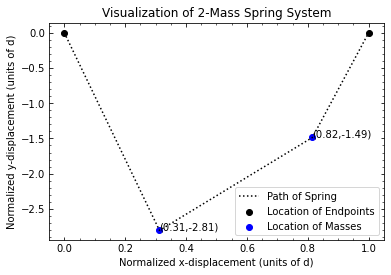

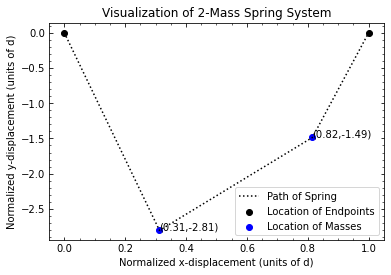

In [124]:
y0 = np.array([1.9,1.55,1.4,np.pi/4.,np.pi/5.,np.pi/8.])
sol_1 = opt.root(static_conditions, y0, args=(l0, kappa, mu), method='hybr')
sol_2 = opt.root(static_conditions, y0, args=(l0, kappa, mu), method='broyden1',tol=1e-12)
sol_1_arr = to_standard_form(sol_1.x[0:3],sol_1.x[3:6])
sol_2_arr = to_standard_form(sol_2.x[0:3],sol_2.x[3:6])
print(f"The solition to the optimization with 'hybr' is {sol_1_arr}, and it converges in {sol_1.nfev} \nfunction evaluations.")
print(f"The solition to the optimization with 'broyden1' is {sol_2_arr}, and it converges in \n{sol_2.nit} iterations.")
print("The second graph is the visualization of the 'broyden1' optimization method; previously, it yielded an invalid solution.\nNow, it yields the unique solution (matching the graph above it).")
visualize_system(sol_1_arr[0:3],sol_1_arr[3:6])
visualize_system(sol_2_arr[0:3],sol_2_arr[3:6]);

## Alternative Approach

Phew, we have solved the problem and completed the lab.  However, we may wonder if there is a better approach that would have avoided the subtleties from the beginning.  The answer is yes.  Here is a suggested alternative approach.  You do not need to implement this yourself, but it should not be too hard to do so.  In particular, you should just need to define a new function, `static_conditions_alt`, and can then reuse your `Jacobian` and `newton_raphson_iterate` functions.

A better approach is to just do everything in terms of vectors.  When we first start using vectors in introductory physics we often complain and think they are needlessly complicated.  The approach we have used in this lab seems far more natural to us.  Hopefully, as we learn more we recognize that vectors, in fact, make things significantly easier and are a much better way to approach problems.  Further, they allow us to very easily generalize the problem as discussed in the previous lab.  One way to represent this system is shown below.

![Static mass-spring system with vectors.](https://github.com/cwru-phys-250/p250-spring-2021/raw/main/figures/static_springs_vectors.png)

Here we allow for an arbitrary origin to our coordinate system and specify the locations of the supports as the vectors $\vec R_j$ (we could easily have more than two) and the locations of massess as $\vec r_j$ (again, we could easily have more than two).  Our objective is to find these $\vec r_j$ given $\vec R_j$, and the same parameters for the springs, $\kappa_i$, and the masses, $\mu_j$.  The red arrows in the figure represent the length vectors for the springs, $\vec\ell_i$.

Notice that now we are only solving for the positions of the masses.  This means solving for four quantities, not six!  We thus only need four equations, all of which come from Newton's second law.  This raises some questions.
- What happened to the extra quantities/extra conditions that were required in our original fomulation?
- Where are the angles in this new formulation?
- Why is this system non-linear?  The spring force is linear in the displacement after all.
- How do we naturally avoid the issue we encountered in our solution developed over the past two labs?

In answering these questions we see the power (and beauty) of using vectors!

## Member Participation

See Lab00 for instructions on turning in labs.  We will follow this procedure the entire semester.

In the following cell enter the *Case ID* for each student in the group who partcipated in this lab.  Again, see Lab00 for more details.  It is expected that you have read and understood those details.

cbf22 ajm305 yxj432 jeb267